In [1]:
import pickle
import datetime
from dateutil.relativedelta import relativedelta
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import array
import tensorflow as tf
import warnings
from tqdm import tqdm_notebook as tqdm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly as py
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pylab as plt
import math
import pickle
import os
import pandas as pd
import folium
import math
import numpy as np
import matplotlib
import covsirphy as cs
from itertools import cycle
sns.set()
matplotlib.use('nbagg')
warnings.filterwarnings("ignore")

In [2]:
# %cd "../../"

In [3]:
%matplotlib inline
import covsirphy as cs

# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving linelist from Open COVID-19 Data Working Group repository: https://github.com/beoutbreakprepared/nCoV2019
Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


In [4]:
train = jhu_data.cleaned()
countries = train["Country"].unique()
total_data = []
days_moving_average = 3


for country in countries:
    try:
        s = cs.Scenario(jhu_data, population_data, country=country)
        s.complement()
        diff = s.records_diff(variables=["Confirmed"], window=days_moving_average, show_figure=False)
        d = s.records(show_figure=False)
        
        # Add country name and number of new confirmed cases
        d["Country"] = country
        d["New Confirmed"] = diff.reset_index()["Confirmed"]
        d = d[:-3]
        total_data.append(d)
    except:
        print(country + " not found")
        

American Samoa not found
Others not found
South Korea not found
Tajikistan not found


In [5]:
train_df = pd.concat(total_data)
train_df.head()

,Date,Confirmed,Infected,Fatal,Recovered,Country,New Confirmed
0,2020-03-20,29,28,0,1,Afghanistan,4.0
1,2020-03-21,30,29,0,1,Afghanistan,4.0
2,2020-03-22,34,32,1,1,Afghanistan,14.0
3,2020-03-23,41,39,1,1,Afghanistan,13.0
4,2020-03-24,43,41,1,1,Afghanistan,16.0


In [6]:

def pred(model, data):
    y_pred = model.predict(data)
    return y_pred


def forcast(model, data, start_date, num_days, n_steps, regs):
    """
    Utility method for Forcasting
    model - trained model on Confirmed/Deaths data
    start_date - Starting date of forcasting
    num_days - Number of days for which forcasting is required
    """
    res_ = dict()
    for i in range(len(data)):
        res_[i] = []
    y_pred = pred(model, data)
    dates = []
    date1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")

    for j in range(1, num_days+1):
        for i in range(len(data)):
            cur_window = list(data[i][0][1: n_steps+1])
            res_[i].append(cur_window[-1])
            cur_window.append(y_pred[i])
            data[i][0] = cur_window
        y_pred = pred(model, data)
        dates.append(date1.strftime("%Y-%m-%d"))
        date1 += relativedelta(days=1)
    res = pd.DataFrame(pd.DataFrame(pd.DataFrame(res_).values.T))
    res.columns = dates
    res['Country/State'] = regs
    return res


def get_countrywise_forcast_(
    covid_timeseries,
    res_regional,
    target,
    country_name,
    state_name,
    num_days,
    begin_date,
    ):
    temp = covid_timeseries[covid_timeseries['Country/Region']
                            == country_name].query('ObservationDate>='
            + begin_date)
    x_truth = temp.ObservationDate
    y_truth = temp[target]
    pred_ = res_regional[res_regional['Country/Region'] == country_name]
    x_pred = pred_.Date[0:num_days]
    y_pred = (pred_[target])[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))



def get_countrywise_forcast(
    train,
    res_regional,
    country_name,
    state_name,
    num_days,
    begin_date,
    ):
    temp = train[train['Country/Region']
                 == country_name].query('ObservationDate>='
            + begin_date)
    x_truth = temp.ObservationDate
    y_truth = temp.Confirmed
    pred_ = res_regional[res_regional['Country/Region'] == country_name]
    x_pred = pred_.Date[0:num_days]
    y_pred = pred_.ConfirmedCases[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))


# Call only when forcast and submission data are available
def get_countrywise_forcast_Deaths(country_name, state_name, num_days):
    temp = train[(train['Country/Region'] == country_name)
                 & (train['Province/State']
                 == state_name)].query('ObservationDate>=' + pivot_date)
    x_truth = temp.ObservationDate
    y_truth = temp.Deaths
    pred_ = res_regional[(res_regional['Country_Region']
                         == country_name)
                         & (res_regional['Province_State']
                         == state_name)]
    x_pred = pred_.Date[0:num_days]
    y_pred = pred_.Fatalities[0:num_days]
    return (list(x_truth), list(y_truth), list(x_pred), list(y_pred))


# Utility Method to convert newly added prediction to cumulative [Not Accurate]
def get_cumulative_confirmed_cases(world_data_):
    world_data_ = world_data_.sort_values(['Country_Region', 'Date'])
    world_data_['Cumulative Confirmed'] = world_data_['New Confirmed']
    for i in tqdm(range(1, len(world_data_))):
        if world_data_['Country_Region'].iloc[i] \
            != world_data_['Country_Region'].iloc[i - 1]:
            world_data_['Cumulative Confirmed'].iloc[i] = \
                world_data_['ConfirmedCases'].iloc[i]
    for i in tqdm(range(1, len(world_data_))):
        if world_data_['Country_Region'].iloc[i] \
            == world_data_['Country_Region'].iloc[i - 1]:
            world_data_['Cumulative Confirmed'].iloc[i] = \
                world_data_['Cumulative Confirmed'].iloc[i] \
                + world_data_['Cumulative Confirmed'].iloc[i - 1]
    return world_data_


# function to create training data for LSTM
# We will take last 7 days Cases as input and 8th day's case as output
def create_train_dataset(target, n_steps, train, pivot_date,
                         unique_regions, states_per_regions):
    train = train.query("ObservationDate<"+pivot_date)
    x, y =[], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = list(temp[target])
            for i in range(len(sequence)):
                end_ix = i + n_steps
                if end_ix > len(sequence) - 1:
                    break
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                if(seq_y != 0):
                    x.append(seq_x)
                    y.append(seq_y)
    return array(x), array(y)


def create_countrywise_newly_added_train_dataset(target,
                                                n_steps,
                                                train,
                                                pivot_date):
    train = train.query("ObservationDate<"+pivot_date)
    x, y = [], []
    for k in tqdm(range(len(unique_regions))):
        temp = train[(train['Country/Region']==unique_regions[k])]
        sequence = list(temp[target])
        for i in range(len(sequence)):
            end_ix = i + n_steps
            if end_ix > len(sequence)-1:
                break
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            if( seq_y != 0):
                x.append(seq_x)
                y.append(seq_y)
    return array(x), array


def create_test_dataset_new_c(target, n_steps, train,pivot_date, unique_regions,
                        states_per_regions):
    train = train.query("ObservationDate<"+pivot_date)
    x, regs = [], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = temp[target].values
            x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
            regs.append((unique_regions[k],state))  
    return x, regs


def create_test_dataset(target, n_steps, train,pivot_date, unique_regions,
                        states_per_regions):
    """
    Function to create test dataset
    our supervised probem is now given last 7 days data predict 
    the no of cases for 8th day;
    target : 'Confirmed'/'Deaths'
    """

    train = train.query("ObservationDate<"+pivot_date)
    x, regs = [], []
    for k in tqdm(range(len(unique_regions))):
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k])]
            sequence = temp[target]
            x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
            regs.append((unique_regions[k],state))  
    return array(x), regs


def create_countrywise_newly_added_test_dataset(target,n_steps,train,pivot_date):
    train = train.query("ObservationDate<"+pivot_date)
    x=[]
    regs=[]
    for k in tqdm(range(len(unique_regions))):
        temp=train[(train['Country/Region']==unique_regions[k])]
        sequence=temp[target]
        #print(sequence[len(sequence)-n_steps:len(sequence)+1])
        x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
        regs.append(unique_regions[k])      
    return array(x),regs

def get_newly_added(world_data_):
    world_data_=world_data_.sort_values(['Country/Region','ObservationDate'])
    temp=[0*i for i in range(len(world_data_))]
    world_data_['New Confirmed']=temp
    world_data_['New Death']=temp
    for i in tqdm(range(1,len(world_data_))):
        if(world_data_['Country/Region'].iloc[i]==world_data_['Country/Region'].iloc[i-1]):
            if(world_data_['Deaths'].iloc[i]<world_data_['Deaths'].iloc[i-1]):
                world_data_['Deaths'].iloc[i]=world_data_['Deaths'].iloc[i-1]
            if(world_data_['Confirmed'].iloc[i]<world_data_['Confirmed'].iloc[i-1]):
                world_data_['Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i-1]     
            world_data_['New Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i]-world_data_['Confirmed'].iloc[i-1]
            world_data_['New Death'].iloc[i]=world_data_['Deaths'].iloc[i]-world_data_['Deaths'].iloc[i-1]
        else:
            world_data_['New Confirmed'].iloc[i]=world_data_['Confirmed'].iloc[i]
            world_data_['New Death'].iloc[i]=world_data_['Deaths'].iloc[i]
    return world_data_

def list_per_region(train):
  # Creating list of all regions of all counntries
    unique_regions = train['Country/Region'].unique()
    states_per_regions = []
    for reg in tqdm(unique_regions):
        states_per_regions.append(
            train[train['Country/Region'] == reg]['Country/Region'].unique())
    return states_per_regions, unique_regions

def prepare_submission(res_c, res_d, res_nc, test, pivot_date, end_date): 
    test = test.query("Date>="+pivot_date)
    test = test.query("Date<="+end_date)
    index=dict()
    for i in range(len(res_c)):
        index[res_c.iloc[i]['Country/State'][0]]=i
    pred_c=[]
    pred_d=[]
    pred_nc=[]
    for i in tqdm(range(len(test))):
        if(test.iloc[i]['Country/Region'] in index):
            loc=index[test.iloc[i]['Country/Region']]
            date = datetime.datetime.strftime(test.iloc[i]['Date'].date(), format="%Y-%m-%d")
            
            pred_c.append(res_c.iloc[loc][date])     
            pred_d.append(res_d.iloc[loc][date]) 
            pred_nc.append(res_nc.iloc[loc][date]) 

    test['ConfirmedCases']=pred_c
    test['Fatalities']=pred_d
    test['New Confirmed']=pred_nc
    res_regional=test
    res=test.drop(columns=['Country/Region','Date','New Confirmed'])
    return res, res_regional

def convert_predictions_df(res_nc, test, pivot_date, end_date):
    test = test.query("Date>="+pivot_date)
    test = test.query("Date<="+end_date)
    index=dict()
    for i in range(len(res_nc)):
        index[res_nc.iloc[i]['Country/State'][0]]=i

    pred_nc=[]
    for i in tqdm(range(len(test))):
        if(test.iloc[i]['Country/Region'] in index):
            loc=index[test.iloc[i]['Country/Region']]
            date = datetime.datetime.strftime(test.iloc[i]['Date'].date(), format="%Y-%m-%d")
            pred_nc.append(res_nc.iloc[loc][date]) 

    test['New Confirmed']=pred_nc
    res_regional=test
    res=test.drop(columns=['Country/Region','Date','New Confirmed'])
    return res, res_regional

train = train_df.rename(columns={'Country': 'Country/Region','Fatal': 'Deaths', 'Date': 'ObservationDate'})
covid_timeseries = train.copy()

num_cols = ['Confirmed', 'Deaths']
for col in num_cols:
    temp = [int(i) for i in train[col]]
    train[col] = temp

# Create empty test set
countries = train["Country/Region"].unique()
dates = list(train[train["Country/Region"] == countries[0]].ObservationDate)

d = []
for country in countries:
    for date in dates:
        d.append(
            {
                'Country/Region': country,
                'Date': date,
            }
        )

test = pd.DataFrame(d)

states_per_regions, unique_regions = list_per_region(test)

# Number of steps to look back
n_steps = 5

# Number of days to forcast
num_days = 30

country = "Netherlands"
pivot_date = "'2020-11-26'"
save_file_str = "NL_nov"

# pivot_date = "'2020-12-01'"
num_days = int(num_days)
print('Preparing datasets with Cumulative Confirmed Incidents..')
X_c, y_c = create_train_dataset('Confirmed', n_steps, train, pivot_date, unique_regions, states_per_regions)
print('Preparing datasets with Newly Confirmed Incidents..')
X_nc, y_nc = create_train_dataset(
    'New Confirmed', n_steps, covid_timeseries, pivot_date, unique_regions, states_per_regions)
test_confirmed, regs = create_test_dataset(
    'Confirmed', n_steps, train, pivot_date, unique_regions, states_per_regions)
test_nc, reg_nc = create_test_dataset_new_c(
    'New Confirmed', n_steps, covid_timeseries, pivot_date, unique_regions, states_per_regions)
print('Preparing datasets with Deaths Incidents..')
X_d, y_d = create_train_dataset('Deaths', n_steps, train, pivot_date, unique_regions, states_per_regions)
test_deaths, regs = create_test_dataset('Deaths', n_steps, train, pivot_date, unique_regions, states_per_regions)
print('Datasets prepared sucessfully.')

# Split the train data in to train and val data
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(
    X_c, y_c, test_size=0.30, random_state=42)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(
    X_d, y_d, test_size=0.30, random_state=42)
X_train_nc, X_val_nc, y_train_nc, y_val_nc = train_test_split(
    X_c, y_c, test_size=0.30, random_state=42)

# Reshape data
test_confirmed = pd.DataFrame(test_confirmed).values
test_nc = pd.DataFrame(test_nc).values
test_deaths = pd.DataFrame(test_deaths).values


# Reshapping the Confirmed data for LSTM
X_train_c = X_train_c.reshape((X_train_c.shape[0], 1, X_train_c.shape[1]))
X_val_c = X_val_c.reshape((X_val_c.shape[0], 1,  X_val_c.shape[1]))
X_train_nc = X_train_nc.reshape((X_train_nc.shape[0], 1, X_train_nc.shape[1]))
X_val_nc = X_val_nc.reshape((X_val_nc.shape[0], 1,  X_val_nc.shape[1]))
X_test_c = test_confirmed.reshape(
    (test_confirmed.shape[0], 1, test_confirmed.shape[1]))
X_test_nc = test_nc.reshape((test_nc.shape[0], 1, test_nc.shape[1]))


# Reshapping the donfirmed data for LSTM
X_train_d = X_train_d.reshape((X_train_d.shape[0], 1, X_train_d.shape[1]))
X_val_d = X_val_d.reshape((X_val_d.shape[0], 1,  X_val_d.shape[1]))
X_test_d = test_deaths.reshape((test_deaths.shape[0], 1, test_deaths.shape[1]))

# Initializing model components
epochs = 15
batch_size = 32
n_hidden = 32
timesteps = X_train_c.shape[1]
input_dim = X_train_c.shape[2]
n_features = 1

# Stacked LSTM Model
model_nc = Sequential()
model_nc.add(LSTM(50, activation='relu', input_shape=(n_features,n_steps),return_sequences=True))
model_nc.add(LSTM(50, activation='relu'))
model_nc.add(Dense(1))
model_nc.summary()
model_nc.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError())
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
            EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# fit the model
hist=model_nc.fit(X_train_nc,y_train_nc, epochs=epochs, batch_size=batch_size, validation_data=(X_val_nc, y_val_nc), verbose=2, 
            shuffle=True,callbacks=callbacks)

# pivot_date = "'2020-08-23'"
# forcast_start_date  = "2020-03-01"
forcast_start_date = pivot_date.replace("'", "")
res_new_confirmed = forcast(model_nc,X_test_nc,forcast_start_date,num_days, n_steps, regs)

# begin_date = f"'{forcast_start_date}'"
begin_date = pivot_date
end_date = f"'{res_new_confirmed.columns[-2:][0]}'"

sub, res_regional = convert_predictions_df(res_new_confirmed,test,begin_date, end_date)
display(res_regional)

country = "Netherlands"
x_truth_It,y_truth_It,x_pred_It,y_pred_It=get_countrywise_forcast_(covid_timeseries, res_regional, 'New Confirmed',country ,'NoState',num_days, begin_date)
new_dict = {"x_truth_It": x_truth_It,
        "y_truth_It": y_truth_It,
        "x_pred_It": x_pred_It,
        "y_pred_It": y_pred_It}

print("Finished")
    



Preparing datasets with Cumulative Confirmed Incidents..



Preparing datasets with Newly Confirmed Incidents..



Preparing datasets with Deaths Incidents..



Datasets prepared sucessfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             11200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,451
Trainable params: 31,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
994/994 - 3s - loss: 0.6755 - val_loss: 0.0021
Epoch 2/15
994/994 - 3s - loss: 0.0017 - val_loss: 0.0015
Epoch 3/15
994/994 - 3s - loss: 0.0016 - val_loss: 0.0015
Epoch 4/15
994/994 - 3s - loss: 0.0016 - val_loss: 0.0015
Epoch 5/15
994/994 - 3s - loss: 0.0016 - val_loss: 0.0015
Epoch 6/15
994/994 - 3s - loss: 0.0015 - val_loss: 0.0023
Ep

,Country/Region,Date,New Confirmed
251,Afghanistan,2020-11-26,153.000000
252,Afghanistan,2020-11-27,161.411789
253,Afghanistan,2020-11-28,160.694641
254,Afghanistan,2020-11-29,149.354675
255,Afghanistan,2020-11-30,142.286453
...,...,...,...
56342,Japan,2020-12-21,3731.357666
56343,Japan,2020-12-22,3695.385986
56344,Japan,2020-12-23,3658.523926
56345,Japan,2020-12-24,3621.082275


Finished


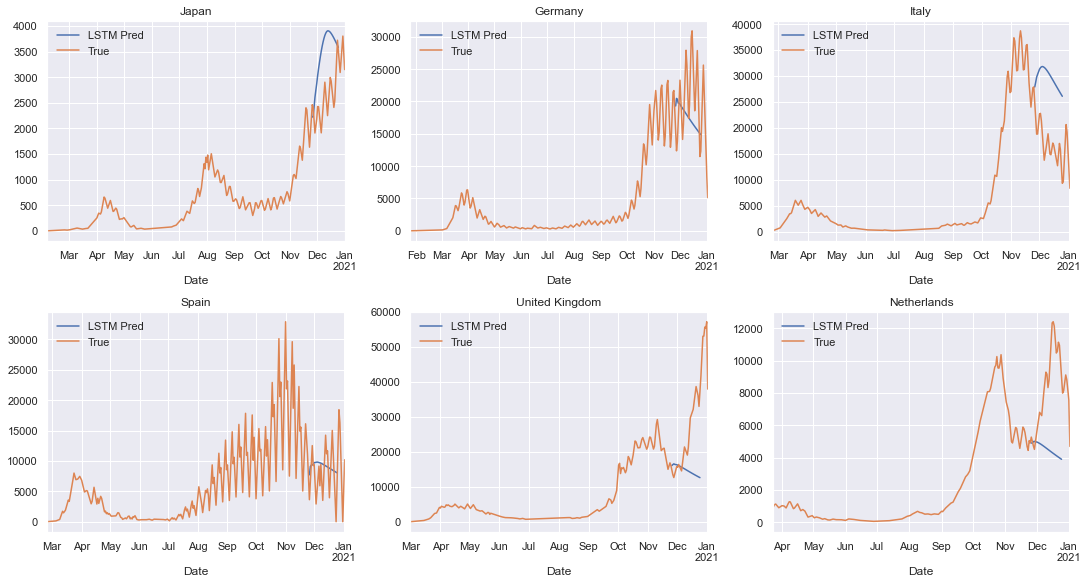

In [7]:
countries = ["Japan", "Germany", "Italy", "Spain", "United Kingdom", "Netherlands"]
nrow, ncol = 2, 3
colors = map('C{}'.format, cycle(range(nrow*ncol)))
fig, axs = plt.subplots(nrow,ncol,figsize=(ncol*5, nrow*4), constrained_layout=True);

for country, ax in zip(countries, axs.flatten()):
    res_regional[res_regional["Country/Region"] == country].plot(x="Date", y="New Confirmed", label="LSTM Pred", ax=ax)
    train_df[train_df["Country"] == country].plot(x="Date", y="New Confirmed", ax=ax, label="True", title=country);

### Make SIR predictions and insert predictions into X_test_nc at the right location (match location on country) 

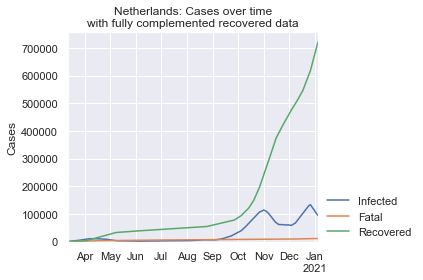

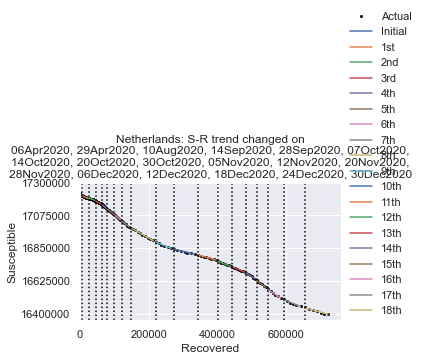


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	17th phase (29Apr2020 - 09Aug2020): finished 1431 trials in 3 min 23 sec
	13th phase (28Nov2020 - 05Dec2020): finished  550 trials in 0 min 50 sec
	 4th phase (07Oct2020 - 13Oct2020): finished  640 trials in 1 min  0 sec
	10th phase (05Nov2020 - 11Nov2020): finished  476 trials in 1 min  0 sec
	 1st phase (14Oct2020 - 19Oct2020): finished  717 trials in 1 min 31 sec
	14th phase (24Dec2020 - 29Dec2020): finished 1455 trials in 3 min  2 sec
	11th phase (06Apr2020 - 28Apr2020): finished 1411 trials in 3 min  2 sec
	 5th phase (12Dec2020 - 17Dec2020): finished  536 trials in 0 min 50 sec
	16th phase (28Sep2020 - 06Oct2020): finished  205 trials in 0 min 20 sec
	 9th phase (14Sep2020 - 27Sep2020): finished 1430 trials in 3 min  2 sec
	 2nd phase (30Dec2020 - 05Jan2021): finished  711 trials in 1 min 20 sec
	 0th phase (06Dec2020 - 11Dec2020): finished  504 trials in 0 min 50 sec
	 8th phase (11Mar2020 - 05Apr2020): fi

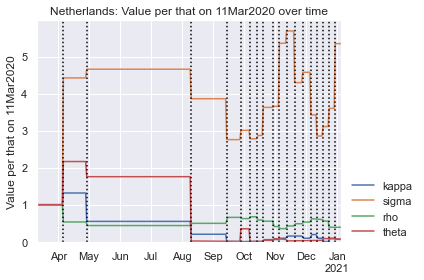

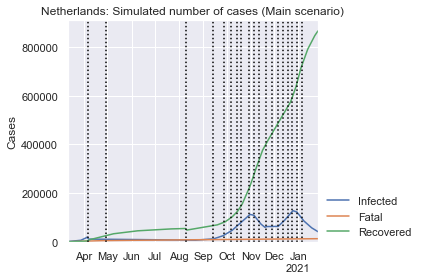

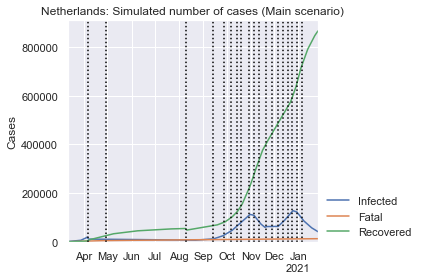

,Date,Confirmed,Fatal,Infected,Recovered
317,2021-01-22,908167,12305,48514,847348
318,2021-01-23,911287,12330,46598,852359
319,2021-01-24,914285,12355,44757,857173
320,2021-01-25,917164,12378,42989,861797
321,2021-01-26,919930,12401,41288,866241


In [8]:
country = "Netherlands"
snl = cs.Scenario(jhu_data, population_data, country=country)
data = snl.records()
trend = snl.trend()

# Parameter estimation of SIR model
snl.estimate(cs.SIRF)

# History 
_ = snl.history_rate()
# Simulation for n days
snl.add(days=20)
_ = snl.simulate()

plot = snl.simulate();
df_SIR = plot

# Make a slice of the predictions as input
df_SIR_slice = df_SIR.iloc[-30:]
df_SIR_slice.tail()


In [11]:
# Calculate moving average of new confirmed cases
window = days_moving_average
new = plot["Confirmed"].diff().dropna()
new = new.rolling(window=window).mean().dropna().astype(np.int64)
plot["New Confirmed"] = new
# ax = plot.plot(x="Date", y="New Confirmed", label="SIR Pred", title="Number of new confirmed cases in the Netherlands")
# res_regional[res_regional["Country/Region"] == country].plot(x="Date", y="New Confirmed", label="LSTM Pred", ax=ax)
# train_df[train_df["Country"] == country].plot(x="Date", y="New Confirmed", ax=ax, label="True");


### Insert SIR predictions as input for LSTM model

In [107]:
# Number of days to add to test-set
relative_days = 70

# Convert data to correct format
plot["Country/Region"] = country
plot = plot.dropna()
SIR_df = plot.rename(columns={"Date": "ObservationDate"})

display(SIR_df["ObservationDate"][-n_steps:].values)
print(SIR_df["New Confirmed"].values[-n_steps:])
base = SIR_df["ObservationDate"][-n_steps:].values[0]
ts = (base - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
ts = datetime.datetime.utcfromtimestamp(ts)

# Replace values in the test set with new predicted values
index=dict()
for i in range(len(res_new_confirmed)):
    index[res_new_confirmed.iloc[i]['Country/State'][0]]=i

X_test_nc_copy = X_test_nc.copy()
print("Before", X_test_nc_copy[index[country]])
X_test_nc_copy[index[country]][0] = SIR_df["New Confirmed"].values[-n_steps:]
print("After",  X_test_nc_copy[index[country]])

# Get last day SIR predictions and update testset
delta_ns = plot.iloc[-1:]["Date"].values[0] - test.iloc[-1:]["Date"].values[0]
days = delta_ns.astype('timedelta64[D]')
days = int(days / np.timedelta64(1, 'D'))

test_copy = test.copy()
for index, row in test_copy.iterrows():
    new_date = row["Date"] + datetime.timedelta(days=days + relative_days)
    test_copy.at[index,'Date'] = new_date
test_copy

array(['2021-01-22T00:00:00.000000000', '2021-01-23T00:00:00.000000000',
       '2021-01-24T00:00:00.000000000', '2021-01-25T00:00:00.000000000',
       '2021-01-26T00:00:00.000000000'], dtype='datetime64[ns]')

[3387. 3252. 3123. 2999. 2881.]
Before [[4037.12963867 3991.94433594 3947.25195312 3903.0546875  3859.35229492]]
After [[3387. 3252. 3123. 2999. 2881.]]


,Country/Region,Date
0,Afghanistan,2020-06-22
1,Afghanistan,2020-06-23
2,Afghanistan,2020-06-24
3,Afghanistan,2020-06-25
4,Afghanistan,2020-06-26
...,...,...
56350,Japan,2021-04-02
56351,Japan,2021-04-03
56352,Japan,2021-04-04
56353,Japan,2021-04-05


In [108]:
# Number of days to forecast
num_days = 100

pivot_date = f"'{ts.date()}'"
print(pivot_date)
forcast_start_date = pivot_date.replace("'", "")
new_confirmed_SIR = forcast(model_nc,X_test_nc_copy,forcast_start_date,num_days, n_steps, regs)

begin_date = f"'{forcast_start_date}'"
begin_date = pivot_date
end_date = f"'{new_confirmed_SIR.columns[-2:][0]}'"

sub, res_regional = convert_predictions_df(new_confirmed_SIR,test_copy, begin_date, end_date)
res_country = res_regional[res_regional["Country/Region"] == country]

# Append to existing predictions
# date_list = [ts - datetime.timedelta(days=x) for x in range(num_days)]
# res_country["Date"] = date_list

'2021-01-22'


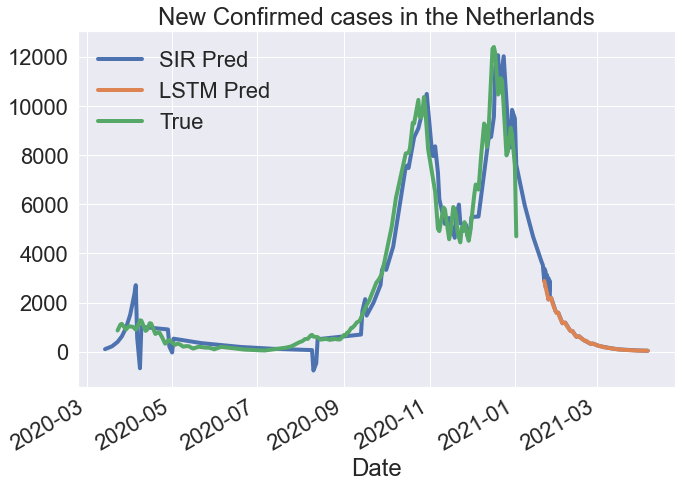

In [109]:
sns.set(rc={'figure.figsize':(10.7,7.27)})
sns.set(font_scale=2)

concat_df = pd.concat([plot, res_country])
ax = concat_df.plot(x="Date", y="New Confirmed", label="SIR Pred", title="New Confirmed cases in the Netherlands", linewidth=4)
res_country.plot(x="Date", y="New Confirmed", label="LSTM Pred", ax=ax,  linewidth=4)
train_df[train_df["Country"] == country].plot(x="Date", y="New Confirmed", ax=ax, label="True",  linewidth=4);